# **Swarm Robotics Competitions**

### 2021/2022      

## A. Pedro Aguiar
<pedro.aguiar@fe.up.pt>
<br>

<br> FEUP Nov. 2021


# Competition Swarm Robotics



### **A swarm of 5 agents with a leader agent** steering to resource $R_1$


Consider a fleet of n=5 agents (robots), and let agent 1 be the leader.

Consider also that:
- leader 1 has access to its position $\xi_1$
- all the other agents only have access to the relative position with respect to the other agents, that is, $\xi_{ij}=\xi_i-\xi_j$.  This is only true if they are close to each other (maximum range of 2m), otherwise the relative position is null.
- all the agents have access to the closest distance and angle (direction) of the nearest obstacle, that is, $d_{io}$ and $\theta_{io}$.

**Goal:** Reach the resource $R_1$ with at least 2 agents.

**Solution:** From the notebook "*Motion control of a single agent*", one option is to assign to agent 1 (leader) the feedback control law

$$
u_1 = - K_1 (\xi_1-\xi_d) + \frac{k_{1o}(d_{1o})}{d_{1o}^2} ( \xi_1 - \xi_o ) + \dot{\xi}_d, \quad
k_{1o}(d_{1o}) = \bar k_{1o}e^{-c d_{1o}^2},
$$

where
$K_1, k_{1o}, c$ are positive gains, $d_{1o}$ is the range to the nearest obstacle, $\xi_o$ is the center of the obstacle, and 

$$
\xi_d = R_1, \quad \dot\xi_d = 0
$$







Note that the above law cannot be implementable because we don't know $\xi_0$ !

But we can consider $\xi_0$ to be the closest point of the obstacle to the agent. In that case, we get $\xi_0= \xi_1+[d_{1o}\cos\theta_{1o}, d_{1o}\sin\theta_{1o}]^T$, and therefore, the control law simplifies to

$$
u_1 = - K_1 (\xi_1-\xi_d) - \frac{k_{1o}(d_{1o})}{d_{1o}} 
\left[
\begin{array}{c}
\cos\theta_{1o} \\
\sin\theta_{1o}
\end{array}
\right]
$$
where $d_{1o}$ and $\theta_{1o}$ is the range and angle of agent $i$ to the nearest obstacle.

To make sure that the other agents follow the leader, we set 

$$
u_i = - K_i \sum_{j\in N_i}\big(\xi_{ij} -b_{ij}\big) + \sum_{j= 1}^n \frac{k_{ij}(d_{ij})}{d_{ij}^2}  \xi_{ij} - \frac{k_{io}(d_{io})}{d_{io}} 
\left[
\begin{array}{c}
\cos\theta_{io} \\
\sin\theta_{io}
\end{array}
\right]
+
\dot \xi_d, \quad i=2, 3,\ldots n
$$

$$
d_{ij} = ||\xi_{ij}||, \quad
%d_{io} = ||\xi_i - \xi_o ||
$$



where $K_i$ is a $2\times 2$ positive-definite matrix gain, and the bias terms $b_{ij}= -b_{ji}$ specifies the formation configuration.



In [4]:
import math
import numpy as np
from dynamic_systems import Integrator, Line, Ellipse, World, ConvexPolygon

# World arena
arena = ConvexPolygon([[ 10.0, -10.0 ],
                       [ 10.0, 10.0 ],
                       [ -10.0, 10.0 ],
                       [ -10.0, -10.0]])

# World obstacles
obs1 = Ellipse(center = [-1.0, -1.0], angle = np.radians(30.0), axes = [3.0, 1.5])
obs2 = Ellipse(center = [-5.0, 1.0], angle = np.radians(0.0), axes = [1.0, 0.4])
#obs3 = ConvexPolygon([[ 4.0, 0.0 ],
#                      [ 5.0, 1.0 ],
#                      [ 6.0, 0.0 ],
#                      [ 4.0, -1.0]])

# Define world
world = World(arena)
world.add_obstacle(obs1)
world.add_obstacle(obs2)
#world.add_obstacle(obs3)



#######################
# Dynamics: States=[xi] Control=[u] where xi_dot=u
initial_state1 = [0.0, -5.0]
initial_control1 = [0.0, 0.0]
robot1 = Integrator(initial_state1, initial_control1)

initial_state2 = [0.5, -5.0]
initial_control2 = [0.0, 0.0]
robot2 = Integrator(initial_state2, initial_control2)

initial_state3 = [1.0, -5.0]
initial_control3 = [0.0, 0.0]
robot3 = Integrator(initial_state3, initial_control3)

initial_state4 = [1.5, -5.0]
initial_control4 = [0.0, 0.0]
robot4 = Integrator(initial_state4, initial_control4)

initial_state5 = [2.0, -5.0]
initial_control5 = [0.0, 0.0]
robot5 = Integrator(initial_state5, initial_control5)

dt = 0.01
sim_time = 15
time = []
ux1, uy1 = [], []
x1, y1 = [], []
ux2, uy2 = [], []
x2, y2 = [], []
ux3, uy3 = [], []
x3, y3 = [], []
ux4, uy4 = [], []
x4, y4 = [], []
ux5, uy5 = [], []
x5, y5 = [], []
xdv, ydv = [], []

cpx1, cpy1 = [], []
cpx2, cpy2 = [], []
cpx3, cpy3 = [], []
cpx4, cpy4 = [], []
cpx5, cpy5 = [], []

R1 = np.array([0, 5])

In [5]:

# Gain matrix
kx, ky = 1, 1
K = np.diag([kx,ky])

K1o_init = 3*np.diag([1,1])
c = 100

K2o_init = K1o_init
K2j_init = K1o_init
K3o_init = K1o_init
K3j_init = K1o_init
K4o_init = K1o_init
K4j_init = K1o_init
K5o_init = K1o_init
K5j_init = K1o_init

b12 = [0.0, 0.5]
b23 = [0.0, 0.5]
b34 = [0.0, 0.5]
b45 = [0.0, 0.5]

for t in np.linspace(0.0, sim_time, num=int(sim_time/dt)):

    # Time
    time.append(t)

    # Reference signal
#    xid = 10*np.array([ math.sin(t), math.cos(t) ])
#    dot_xid = 10*np.array([ math.cos(t), -math.sin(t) ])
#    xid = 5*np.array([ np.heaviside(t-5,1.0), 0 ])
    xid = R1
    dot_xid = (0,0)


    # Get the state
    state1 = robot1.get_state()
    state2 = robot2.get_state()
    state3 = robot3.get_state()
    state4 = robot4.get_state()
    state5 = robot5.get_state()

    # Control law
    closest_pt, d1o = world.compute_closest(state1)
    angle = np.arctan2(closest_pt[1]-state1[1],closest_pt[0]-state1[0])
    cpx1.append(closest_pt[0])
    cpy1.append(closest_pt[1])
#    u_control1 = - K @ ( state1 - xid ) + (1/d1o**2)*K1o_init*np.exp(-c*d1o**2) @ ( state1 - xo ) + dot_xid
#    u_control1 = - K @ ( state1 - xid ) + (1/d1o**2)*K1o_init*np.exp(-c*d1o**2) @ ( state1 - closest_pt ) + dot_xid
    u_control1 = - K @ ( state1 - xid ) - (1/d1o)*K1o_init*np.exp(-c*d1o**2) @ ( np.cos(angle), np.sin(angle) ) + dot_xid

#    u_control1 = - K @ ( state1 - xid ) + dot_xid
#    u_control1 = (0,0)
    u_control1 = np.clip(u_control1, -1, 1)
#    print("Distance = " + str(d1o))
#    print("angle [deg] = " + str(angle*180/np.pi))
#    print("Closest point = " + str(closest_pt))



    # closest_pt, d2o = world.compute_closest(state2)
    # angle = np.arctan2(closest_pt[1]-state2[1],closest_pt[0]-state2[0])
    # cpx2.append(closest_pt[0])
    # cpy2.append(closest_pt[1])
    # xi21 = state2 - state1    
    # xi23 = state2 - state3
    # xi24 = state2 - state4    
    # xi25 = state2 - state5    
    # u_control2 = - K @ ((xi21+b12)+(xi23-b23)) \
    # + (1/np.linalg.norm(xi21)**2)*K2j_init*np.exp(-c*np.linalg.norm(xi21)**2) @ xi21 \
    # + (1/np.linalg.norm(xi23)**2)*K2j_init*np.exp(-c*np.linalg.norm(xi23)**2) @ xi23 \
    # + (1/np.linalg.norm(xi24)**2)*K2j_init*np.exp(-c*np.linalg.norm(xi24)**2) @ xi24 \
    # + (1/np.linalg.norm(xi25)**2)*K2j_init*np.exp(-c*np.linalg.norm(xi25)**2) @ xi25 \
    # - (1/d2o)*K2o_init*np.exp(-c*d2o**2) @ ( np.cos(angle), np.sin(angle) ) + dot_xid
    # u_control2 = np.clip(u_control2, -1, 1)
    u_control2 = (0,0)


    # closest_pt, d3o = world.compute_closest(state3)
    # angle = np.arctan2(closest_pt[1]-state3[1],closest_pt[0]-state3[0])
    # cpx3.append(closest_pt[0])
    # cpy3.append(closest_pt[1])
    # xi31 = state3 - state1    
    # xi32 = state3 - state2
    # xi34 = state3 - state4    
    # xi35 = state3 - state5    

    # u_control3 = - K @ ((xi32+b23)+(xi34-b34)) \
    # + (1/np.linalg.norm(xi31)**2)*K3j_init*np.exp(-c*np.linalg.norm(xi31)**2) @ xi31 \
    # + (1/np.linalg.norm(xi32)**2)*K3j_init*np.exp(-c*np.linalg.norm(xi32)**2) @ xi32 \
    # + (1/np.linalg.norm(xi34)**2)*K3j_init*np.exp(-c*np.linalg.norm(xi34)**2) @ xi34 \
    # + (1/np.linalg.norm(xi35)**2)*K3j_init*np.exp(-c*np.linalg.norm(xi35)**2) @ xi35 \
    # - (1/d3o)*K3o_init*np.exp(-c*d3o**2) @ ( np.cos(angle), np.sin(angle) ) + dot_xid
    # u_control3 = np.clip(u_control3, -1, 1)
    u_control3 = (0,0)


#    d4o = np.linalg.norm(state4 - xo) - radius    
#    d41 = np.linalg.norm(state4 - state1)    
#    d42 = np.linalg.norm(state4 - state2)    
#    d43 = np.linalg.norm(state4 - state3)    
#    d45 = np.linalg.norm(state4 - state5)    
#    u_control4 = - K @ (((state4 - state3)+b34)+((state4-state5)-b45)) \
#    + (1/d41**2)*K4j_init*np.exp(-c*d41**2) @ ( state4 - state1 ) \
#    + (1/d42**2)*K4j_init*np.exp(-c*d42**2) @ ( state4 - state2 ) \
#    + (1/d43**2)*K4j_init*np.exp(-c*d43**2) @ ( state4 - state3 ) \
#    + (1/d45**2)*K4j_init*np.exp(-c*d45**2) @ ( state4 - state5 ) \
#    + (1/d4o**2)*K4o_init*np.exp(-c*d4o**2) @ ( state4 - xo ) + dot_xid
    u_control4 = (0,0)


#    d5o = np.linalg.norm(state5 - xo) - radius    
#    d51 = np.linalg.norm(state5 - state1)    
#    d52 = np.linalg.norm(state5 - state2)    
#    d53 = np.linalg.norm(state5 - state3)    
#    d54 = np.linalg.norm(state5 - state4)    
#    u_control5 = - K @ ((state5 - state4)+b45) \
#    + (1/d51**2)*K5j_init*np.exp(-c*d51**2) @ ( state5 - state1 ) \
#    + (1/d52**2)*K5j_init*np.exp(-c*d52**2) @ ( state5 - state2 ) \
#    + (1/d53**2)*K5j_init*np.exp(-c*d53**2) @ ( state5 - state3 ) \
#    + (1/d54**2)*K5j_init*np.exp(-c*d54**2) @ ( state5 - state4 ) \
#    + (1/d5o**2)*K5o_init*np.exp(-c*d5o**2) @ ( state5 - xo ) + dot_xid

    u_control5 = (0,0)
    
    # Send actuation commands
    robot1.set_control(u_control1)
    robot1.actuate(dt)
    robot2.set_control(u_control2)
    robot2.actuate(dt)
    robot3.set_control(u_control3)
    robot3.actuate(dt)
    robot4.set_control(u_control4)
    robot4.actuate(dt)
    robot5.set_control(u_control5)
    robot5.actuate(dt)    
    
    ux1.append(u_control1[0])
    uy1.append(u_control1[1])
    x1.append(state1[0])
    y1.append(state1[1])
    ux2.append(u_control2[0])
    uy2.append(u_control2[1])
    x2.append(state2[0])
    y2.append(state2[1])
    ux3.append(u_control3[0])
    uy3.append(u_control3[1])
    x3.append(state3[0])
    y3.append(state3[1])
    ux4.append(u_control4[0])
    uy4.append(u_control4[1])
    x4.append(state4[0])
    y4.append(state4[1])
    ux5.append(u_control5[0])
    uy5.append(u_control5[1])
    x5.append(state5[0])
    y5.append(state5[1])
    




/home/joaocsa/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/joaocsa/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Results:


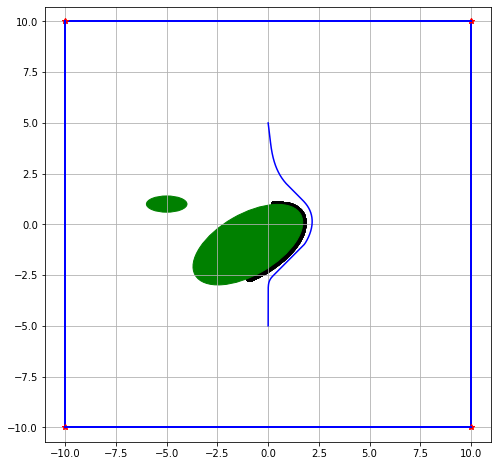

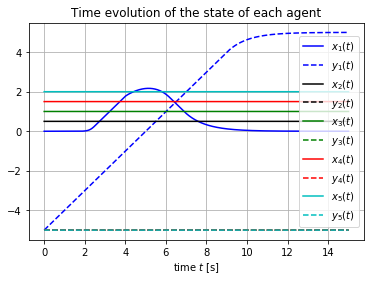

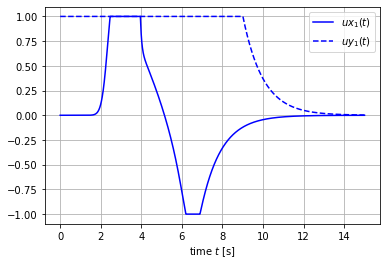

In [6]:
# Plot commands
%matplotlib inline 
#%matplotlib notebook

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))

#plt.figure(figsize=(1,1))
ax.axis('equal')
xdim, ydim = 10, 10
plt.xlim(-xdim-1,xdim+1)
plt.ylim(-ydim-1,ydim+1)
plt.grid()


# Plots walls and obstacles
world.plot()

# Plots point, closest point and distance
#plt.plot(point[0], point[1], marker='o', color='r')
#plt.plot(closest_pt[0], closest_pt[1], marker='*', color='k')
#plt.plot( [closest_pt[0], point[0]], [closest_pt[1], point[1]], color='k')

plt.plot(x1, y1, label='$x_1(t), y_1(t)$', color='b')
plt.scatter(cpx1, cpy1, label='$cpx_1(t), cpy_1(t)$', marker='o', color='k')
plt.plot(x2, y2, label='$x_2(t), y_2(t)$', color='k')
plt.plot(x3, y3, label='$x_3(t), y_3(t)$', color='g')
plt.plot(x4, y4, label='$x_4(t), y_4(t)$', color='r')
plt.plot(x5, y5, label='$x_5(t), y_5(t)$', color='c')


plt.figure()
plt.plot(time, x1, label='$x_1(t)$', color='b')
plt.plot(time, y1, label='$y_1(t)$', color='b', linestyle='dashed')
plt.plot(time, x2, label='$x_2(t)$', color='k')
plt.plot(time, y2, label='$y_2(t)$', color='k', linestyle='dashed')
plt.plot(time, x3, label='$x_3(t)$', color='g')
plt.plot(time, y3, label='$y_3(t)$', color='g', linestyle='dashed')
plt.plot(time, x4, label='$x_4(t)$', color='r')
plt.plot(time, y4, label='$y_4(t)$', color='r', linestyle='dashed')
plt.plot(time, x5, label='$x_5(t)$', color='c')
plt.plot(time, y5, label='$y_5(t)$', color='c', linestyle='dashed')

plt.xlabel('time $t$ [s]')
plt.legend()
plt.grid()
plt.title('Time evolution of the state of each agent');

plt.figure()
plt.plot(time, ux1, label='$ux_1(t)$', color='b')
plt.plot(time, uy1, label='$uy_1(t)$', color='b', linestyle='dashed')
plt.xlabel('time $t$ [s]')
plt.legend()
plt.grid()

print("Results:")